In [191]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import itertools
from numpy import dot
from numpy.linalg import norm
import time
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.model_selection import KFold
from sklearn.metrics import multilabel_confusion_matrix


In [119]:
#LOAD DATA
data = np.load('data.npy', allow_pickle=True)
df = pd.DataFrame(data, columns=['id', 'resnet', 'vit', 'label', 'guess_time'])
# print(type(data))
# # print(data)
# print(df)

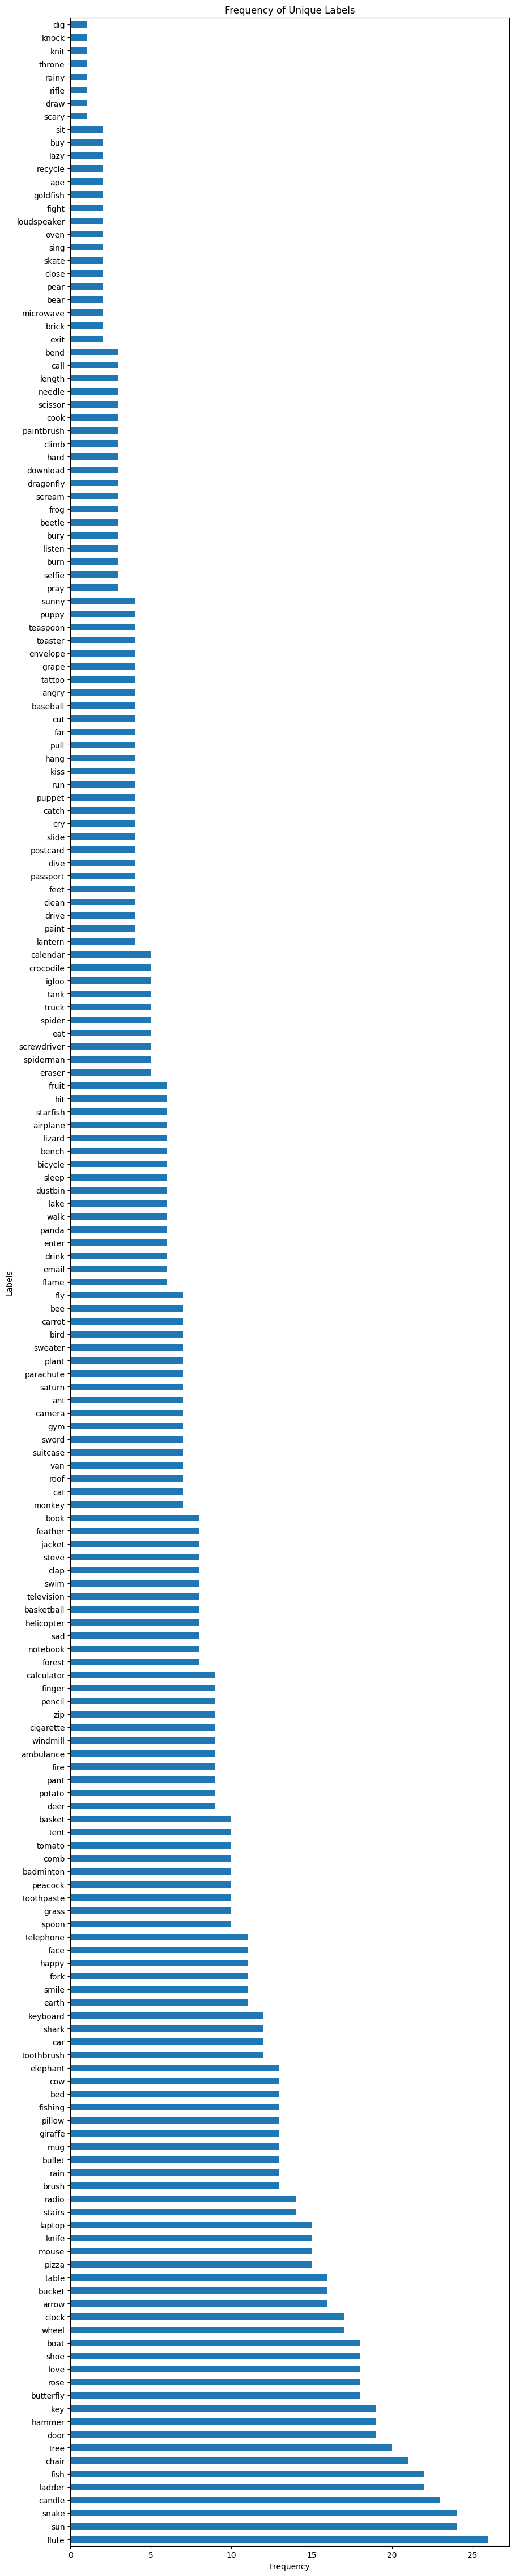

In [120]:
#2.2.1 - HORIZONTAL BAR GRAPH SHOWING FREQUENCY OF EACH LABEL
label_counts = df['label'].value_counts()
plt.figure(figsize=(10, len(label_counts) * 0.3))
label_counts.plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.title('Frequency of Unique Labels')
plt.show()


In [121]:
#splitting data (80-20)
train_data,test_data = train_test_split(data, test_size=0.2, random_state=2)
print(len(train_data),len(test_data))
print(type(train_data))

1200 300
<class 'numpy.ndarray'>


In [122]:
# creating the kNN class
# class structure source - chatgpt
class initial_KNN:
    def __init__(self, k=3, encoder_type='resnet', distance_metric='euclidean'):
        # initialise
        self.k = k
        self.distance_metric = distance_metric
        if encoder_type=='vit':
            self.encoder=1
        elif encoder_type=='resnet':
            self.encoder=0
    
    def fit(self, X, Y):
        self.X_train = X[:,self.encoder]
        self.Y_train = Y

    # cosine distance part source chatgpt   
    def calculate_distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1-x2)**2))
        if(self.distance_metric == 'manhattan'):
            return np.sum(np.abs(x1-x2))
        if(self.distance_metric == 'cosine'):
            distance = dot(x1, np.transpose(x2))/(norm(x1) * norm(x2))
            return 1-distance[0][0]
    
    #sorting indices according to values- source - chatgpt
    def getClass(self, x):
        distances = [self.calculate_distance(x, x_train) for x_train in self.X_train]
        k_nearest_indices = sorted(range(len(distances)), key=lambda i: distances[i])[:self.k]
        k_nearest_labels = [self.Y_train[i] for i in k_nearest_indices]
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]
    
   
    def predict(self, X, Y_actual):
        results={}
        Y_predictions = [self.getClass(x) for x in X]
        results['f1_weighted'] = f1_score(Y_actual, Y_predictions, average='weighted', zero_division=1)
        results['f1_micro'] = f1_score(Y_actual, Y_predictions, average='micro', zero_division=1)
        results['f1_macro'] = f1_score(Y_actual, Y_predictions, average='macro', zero_division=1)
        results['accuracy'] = accuracy_score(Y_actual, Y_predictions)
        results['precision'] = precision_score(Y_actual, Y_predictions, average='weighted', zero_division=1)
        results['recall']= recall_score(Y_actual, Y_predictions, average='weighted', zero_division=1)
        return results


In [123]:
kNN = initial_KNN(5, 'vit')
kNN.fit(train_data[:, 1:3], train_data[:, 3])
result=kNN.predict(test_data[:, 2],test_data[:, 3])
print('Accuracy for hyperparameters = (k=5,vit,euclidean)is ',result['accuracy']*100,"%")

Accuracy for hyperparameters = (k=5,vit,euclidean)is  28.000000000000004 %


In [124]:
kNN = initial_KNN(5, 'resnet')
kNN.fit(train_data[:, 1:3], train_data[:, 3])
result=kNN.predict(test_data[:, 1],test_data[:, 3])
print('Accuracy for hyperparameters = (k=5,resnet,euclidean)is ',result['accuracy']*100,"%")

Accuracy for hyperparameters = (k=5,resnet,euclidean)is  19.333333333333332 %


In [126]:
#hyperparameter tuning

triplets = []
x_train = train_data[:, 1:3]
y_train = train_data[:, 3]

y_test = test_data[:, 3]

for k in [3, 5, 7, 9, 11]:
    for encoder_type in ['resnet', 'vit']:
        for distance_metric in ['euclidean', 'manhattan', 'cosine']:
            kNN = initial_KNN(k, encoder_type, distance_metric)
            kNN.fit(x_train, y_train)
            if(encoder_type=='resnet'):
                X_validation = test_data[:, 1]
            else:
                X_validation = test_data[:, 2]
            results = kNN.predict(X_validation, y_test)
            triplets.append((results['accuracy'], k, encoder_type, distance_metric))
triplets.sort(reverse=True)
triplets = np.asarray(triplets)
df_results = pd.DataFrame({
    "k": triplets[:, 1],
    "encoder_type": triplets[:, 2],
    "distance_metric": triplets[:, 3],
    "accuracy": triplets[:, 0]
})
df_results

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


k encoder_type distance_metric             accuracy
0    7          vit       manhattan  0.29333333333333333
1    5          vit       euclidean                 0.28
2   11          vit       manhattan  0.27666666666666667
3    9          vit       manhattan  0.27666666666666667
4    7          vit       euclidean  0.27666666666666667
5    5          vit          cosine  0.27666666666666667
6    9          vit       euclidean   0.2733333333333333
7    5          vit       manhattan   0.2733333333333333
8   11          vit       euclidean   0.2633333333333333
9    9          vit          cosine   0.2633333333333333
10  11          vit          cosine                 0.26
11   7          vit          cosine                 0.26
12   3          vit       euclidean  0.25666666666666665
13   3          vit       manhattan                 0.25
14   3          vit          cosine  0.23333333333333334
15  11       resnet       manhattan                 0.21
16   5       resnet       manhattan                 0.21
17   7       resnet       manhattan  0.20666666666666667
18   7       resnet          cosine  0.20666666666666667
19  11       resnet          cosine                  0.2
20   9       resnet       manhattan                  0.2
21   9       resnet          cosine                  0.2
22   5       resnet          cosine                  0.2
23   7       resnet       euclidean  0.19333333333333333
24   5       resnet       euclidean  0.19333333333333333
25  11       resnet       euclidean                 0.19
26   9       resnet       euclidean  0.18333333333333332
27   3       resnet       manhattan  0.18333333333333332
28   3       resnet          cosine                 0.18
29   3       resnet       euclidean  0.17666666666666667

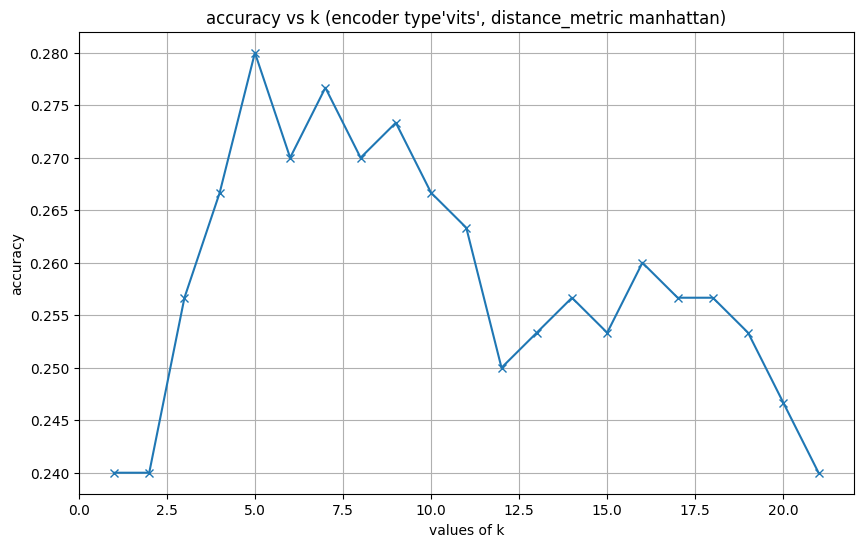

In [ ]:
accuracies=[]
for k in range(1,22):
    kNN = initial_KNN(k, 'vit')
    kNN.fit(train_data[:, 1:3], train_data[:, 3])
    result=kNN.predict(test_data[:, 2],test_data[:, 3])
    accuracies.append(result['accuracy'])
# plot source chatgpt 
#plotting accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 22), accuracies, marker='x')
plt.xlabel('values of k')
plt.ylabel('accuracy')
plt.title("accuracy vs k (encoder type'vits', distance_metric manhattan)")
plt.grid(True)


In [ ]:
#optimised KNN 
#source - argsort , np.dot
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class optimised_KNN:
    def __init__(self, k=3, encoder_type='resnet', distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.encoder = 1 if encoder_type == 'vit' else 0
    
    def fit(self, X, Y):
        self.X_train = X[:, self.encoder]
        self.Y_train = Y

    def calculate_distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        if self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        if self.distance_metric == 'cosine':
            distance = np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
            return 1 - distance

    def getClass(self, x):
        distances = [self.calculate_distance(x, x_train) for x_train in self.X_train]
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.Y_train[i] for i in k_nearest_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def predict(self, X, Y_actual):
        Y_predictions = [self.getClass(x) for x in X]
        results = {}
        results['f1_weighted'] = f1_score(Y_actual, Y_predictions, average='weighted', zero_division=1)
        results['f1_micro'] = f1_score(Y_actual, Y_predictions, average='micro', zero_division=1)
        results['f1_macro'] = f1_score(Y_actual, Y_predictions, average='macro', zero_division=1)
        results['accuracy'] = accuracy_score(Y_actual, Y_predictions)
        results['precision'] = precision_score(Y_actual, Y_predictions, average='weighted', zero_division=1)
        results['recall'] = recall_score(Y_actual, Y_predictions, average='weighted', zero_division=1)
        return results


In [ ]:
kNN = optimised_KNN(5, 'vit')
kNN.fit(train_data[:, 1:3], train_data[:, 3])
result=kNN.predict(test_data[:, 2],test_data[:, 3])
print('Accuracy for hyperparameters = (k=5,vit,euclidean)is ',result['accuracy']*100,"%")

Accuracy for hyperparameters = (k=5,vit,euclidean)is  28.000000000000004 %


In [ ]:
import time

times = []
models = ["Initial Model", "Optimized Model", "sklearn's Model"]

# First model
start_time = time.time()
kNN = initial_KNN(3, 'vit','manhattan')
kNN.fit(train_data[:, 1:3], train_data[:, 3])
result = kNN.predict(test_data[:, 2], test_data[:, 3])
end_time = time.time()
duration = end_time - start_time 
times.append(duration)

# Optimized model
start_time = time.time()
kNN = optimised_KNN(3, 'vit','manhattan')
kNN.fit(train_data[:, 1:3], train_data[:, 3])
result = kNN.predict(test_data[:, 2], test_data[:, 3])
end_time = time.time()
duration = end_time - start_time
times.append(duration)

#data manipulation - source - chatgpt , stackoverflow
X_train = train_data[:, 1:3]
Y_train = train_data[:, 3]
X_validation = test_data[:, 2]
Y_validation = test_data[:, 3]
X_train_sklearn = []
for x in X_train[:, 1]:
    X_train_sklearn.append(x[0])
X_train_sklearn = np.array(X_train_sklearn)
X_validation_sklearn = []
for x in X_validation:
    X_validation_sklearn.append(x[0])
X_validation_sklearn = np.array(X_validation_sklearn)

# default model
start_time = time.time()
sklearn_model = KNeighborsClassifier(n_neighbors = 5, metric='minkowski', p=1)
sklearn_model.fit(X_train_sklearn, Y_train)
Y_predictions = sklearn_model.predict(X_validation_sklearn)
end_time = time.time()
inference_time = end_time-start_time
times.append(inference_time)
print(times)




[4.413962364196777, 4.329261541366577, 0.10499191284179688]


Text(0.5, 1.0, 'Inference Time vs model')

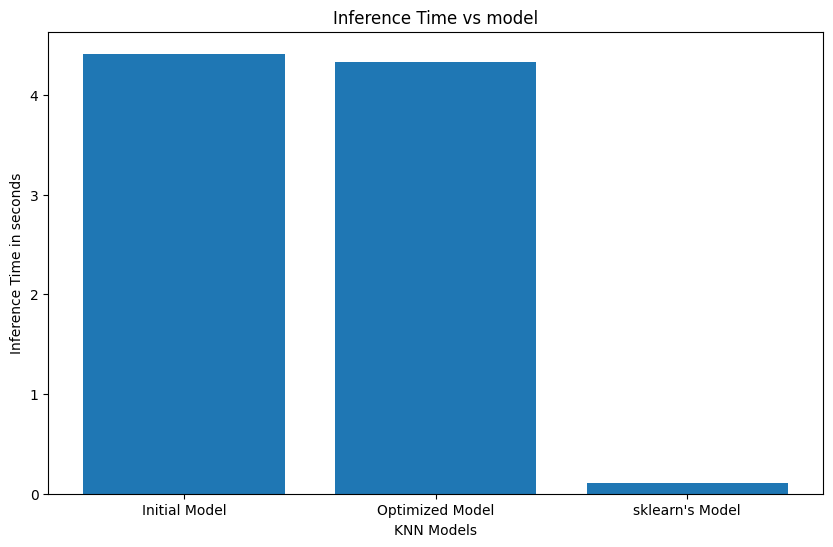

In [ ]:
plt.figure(figsize = (10, 6))
plt.bar(models, times)
plt.xlabel('KNN Models')
plt.ylabel('Inference Time in seconds')
plt.title('Inference Time vs model')

In [ ]:
#inference time vs traing set size

train_sizes = [100, 200,300, 400,500, 600,700, 800, 900,1000,1100, 1200]
first_times = []
optimised_times = []
sklearn_times = []

for size in train_sizes:
    
    # First model
    start_time = time.time()
    kNN = initial_KNN(3, 'vit','manhattan')
    kNN.fit(train_data[:, 1:3][:size], train_data[:, 3][:size])
    result = kNN.predict(test_data[:, 2], test_data[:, 3])
    end_time = time.time()
    duration = end_time - start_time 
    first_times.append(duration)

    # Optimized model
    start_time = time.time()
    kNN = optimised_KNN(3, 'vit','manhattan')
    kNN.fit(train_data[:, 1:3][:size], train_data[:, 3][:size])
    result = kNN.predict(test_data[:, 2], test_data[:, 3])
    end_time = time.time()
    duration = end_time - start_time
    optimised_times.append(duration)

    # default model
    start_time = time.time()
    sklearn_model = KNeighborsClassifier(n_neighbors = 5, metric='minkowski', p=1)
    sklearn_model.fit(X_train_sklearn[:size], Y_train[:size])
    Y_predictions = sklearn_model.predict(X_validation_sklearn[:size])
    end_time = time.time()
    duration = end_time-start_time
    sklearn_times.append(duration)
   




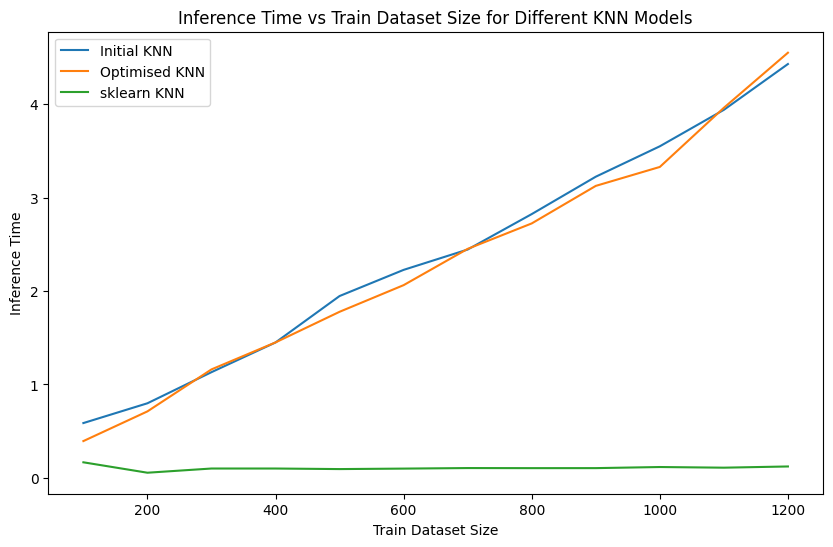

In [ ]:
# plotting inference time vs train-dataset-size for various models
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, first_times, label='Initial KNN')
plt.plot(train_sizes, optimised_times, label='Optimised KNN')
plt.plot(train_sizes, sklearn_times, label='sklearn KNN')
plt.xlabel('Train Dataset Size')
plt.ylabel('Inference Time')
plt.title('Inference Time vs Train Dataset Size for Different KNN Models')
plt.legend()
plt.show()

In [ ]:
#KNN PART OVER 

In [ ]:
#DECISION TREES

In [192]:
#data extraction , processing
data = pd.read_csv('advertisement.csv')
#source for next part : chatgpt
labels= data['labels'].str.split()
encoder = MultiLabelBinarizer()
labels = encoder.fit_transform(labels)
# encoding input feature column
categories = ["gender", "education", "married", "city", "occupation", "most bought item"]
for i in range(len(categories)):
    encoder = LabelEncoder()
    data[categories[i]] = encoder.fit_transform(data[categories[i]])

attributes = data.drop(columns=['labels'])
attributes = attributes.values

In [193]:
# split the data 
X_train, X_test, y_train, y_test = train_test_split(attributes, labels, test_size=0.20, random_state=2)

In [194]:
#source : chatgpt
def hamming_score(y_true: np.ndarray, y_pred: np.ndarray):
    numerator = np.logical_and(y_true, y_pred).sum(axis=1)
    denominator = np.logical_or(y_true, y_pred).sum(axis=1)

    return np.mean(np.divide(numerator, denominator, out=np.ones_like(numerator, dtype=np.float_), where=denominator != 0))


In [195]:
#decision tree using powerset
#class structure source : chatgpt


class Powerset_DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_features = max_features
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = LabelPowerset(
            DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                criterion=self.criterion,
                random_state=2,
            )
        )

    def fit(self, X, y):
        self.tree.fit(X, y)

    def predict(self, X, Y_actual):
        Y_predictions = self.tree.predict(X).toarray()
        metrics = self.calculate_metrics(Y_actual, Y_predictions)
        confusion_matrix = multilabel_confusion_matrix(Y_actual, Y_predictions)
        return Y_predictions,metrics,confusion_matrix

    def calculate_metrics(self, Y_actual, Y_predictions):
        metrics={}
        metrics['f1_micro'] = f1_score(Y_actual, Y_predictions, average='micro', zero_division=1)
        metrics['f1_macro'] = f1_score(Y_actual, Y_predictions, average='macro', zero_division=1)
        metrics['accuracy'] = accuracy_score(Y_actual, Y_predictions)
        metrics['precision'] = precision_score(Y_actual, Y_predictions, average='weighted', zero_division=0)
        metrics['recall'] = recall_score(Y_actual, Y_predictions, average='weighted', zero_division=0)
        metrics['hamming'] = hamming_loss(Y_actual, Y_predictions)
        
        return metrics


In [196]:
Tree = Powerset_DecisionTree(max_depth=5,max_features= 5 ,criterion='gini')
Tree.fit(X_train, y_train)
y_predicted,metrics,c_matrix = Tree.predict(X_test, y_test)
print("predicted values:\n",y_predicted)
print ("metrics:\n")
for i in metrics:
    print(i,":",metrics[i])
print("confusion matrix:\n",c_matrix)



predicted values:
 [[0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
metrics:

f1_micro : 0.28868360277136257
f1_macro : 0.25161142787272117
accuracy : 0.03
precision : 0.43336322837395563
recall : 0.2399232245681382
hamming : 0.385
confusion matrix:
 [[[121   3]
  [ 73   3]]

 [[126   5]
  [ 64   5]]

 [[ 89  48]
  [ 40  23]]

 [[134  12]
  [ 48   6]]

 [[ 75  66]
  [ 28  31]]

 [[ 70  71]
  [ 29  30]]

 [[126  10]
  [ 61   3]]

 [[118   5]
  [ 53  24]]]


In [197]:
#multioutput decision tree

class Multioutput_DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_features = max_features
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = ClassifierChain(
            DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                criterion=self.criterion,
                random_state=2,
            )
        )

    def fit(self, X, y):
        self.tree.fit(X, y)

    def predict(self, X, Y_actual):
        Y_predictions = self.tree.predict(X).toarray()
        metrics = self.calculate_metrics(Y_actual, Y_predictions)
        confusion_matrix = multilabel_confusion_matrix(Y_actual, Y_predictions)
        return Y_predictions,metrics,confusion_matrix

    def calculate_metrics(self, Y_actual, Y_predictions):
        metrics={}
        metrics['f1_micro'] = f1_score(Y_actual, Y_predictions, average='micro', zero_division=1)
        metrics['f1_macro'] = f1_score(Y_actual, Y_predictions, average='macro', zero_division=1)
        metrics['accuracy'] = accuracy_score(Y_actual, Y_predictions)
        metrics['precision'] = precision_score(Y_actual, Y_predictions, average='weighted', zero_division=0)
        metrics['recall'] = recall_score(Y_actual, Y_predictions, average='weighted', zero_division=0)
        metrics['hamming'] = hamming_loss(Y_actual, Y_predictions)
        
        return metrics

In [198]:
Tree = Multioutput_DecisionTree(max_depth=5,max_features=4,criterion='gini')
Tree.fit(X_train, y_train)
y_predicted,metrics,c_matrix = Tree.predict(X_test, y_test)
print("predicted values:\n",y_predicted)
print ("metrics:\n")
for i in metrics:
    print(i,":",metrics[i])
print("confusion matrix:\n",c_matrix)


predicted values:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
metrics:

f1_micro : 0.30494505494505497
f1_macro : 0.2929437940174614
accuracy : 0.035
precision : 0.5803283070472864
recall : 0.21305182341650672
hamming : 0.31625
confusion matrix:
 [[[120   4]
  [ 67   9]]

 [[122   9]
  [ 43  26]]

 [[123  14]
  [ 43  20]]

 [[112  34]
  [ 40  14]]

 [[120  21]
  [ 50   9]]

 [[136   5]
  [ 49  10]]

 [[127   9]
  [ 62   2]]

 [[123   0]
  [ 56  21]]]


In [202]:
# Finding best triplet of parameters
best_powerset = []
best_multioutput = []

for max_features in range(3, 13, 2):
    for max_depth in [3, 5, 10, 20, 30]:
        for criteria in ['gini', 'entropy']:
            # Powerset
            powerset_tree = Powerset_DecisionTree(max_depth=max_depth, max_features=max_features, criterion=criteria)
            powerset_tree.fit(X_train, y_train)
            y_predicted,metrics,c_matrix = powerset_tree.predict(X_test, y_test)
            best_powerset.append((metrics['f1_micro'], metrics['f1_macro'], max_features, max_depth, criteria,metrics['accuracy'],metrics['precision'],metrics['recall'],metrics['hamming']))

            # Multioutput
            multi_tree = Multioutput_DecisionTree(max_depth=max_depth, max_features=max_features, criterion=criteria)
            multi_tree.fit(X_train, y_train)
            y_predicted,metrics,c_matrix  = multi_tree.predict(X_test, y_test)
            best_multioutput.append((metrics['f1_micro'], metrics['f1_macro'], max_features, max_depth, criteria,metrics['accuracy'],metrics['precision'],metrics['recall'],metrics['hamming']))

# Finding best
best_powerset.sort(key=lambda x: x[0], reverse=True)  # Sort by f1_micro in descending order
best_multioutput.sort(key=lambda x: x[0], reverse=True)  # Sort by f1_micro in descending order

# Create DataFrames from the sorted lists
results_powerset = pd.DataFrame({
    'F1_score(micro)': [x[0] for x in best_powerset],
    'F1_score(macro)': [x[1] for x in best_powerset],
    'Criterion': [x[4] for x in best_powerset],
    'Max_depth': [x[3] for x in best_powerset],
    'Max_features': [x[2] for x in best_powerset],
    'accuracy': [x[5] for x in best_powerset],
    'recall': [x[7] for x in best_powerset],
    'precision': [x[6] for x in best_powerset],
    'hamming': [x[8] for x in best_powerset],
})

results_multioutput = pd.DataFrame({
    'F1_score(micro)': [x[0] for x in best_multioutput],
    'F1_score(macro)': [x[1] for x in best_multioutput],
    'Criterion': [x[4] for x in best_multioutput],
    'Max_depth': [x[3] for x in best_multioutput],
    'Max_features': [x[2] for x in best_multioutput],
    'accuracy': [x[5] for x in best_multioutput],
    'recall': [x[7] for x in best_multioutput],
    'precision': [x[6] for x in best_multioutput],
    'hamming': [x[8] for x in best_multioutput],
})


In [203]:
results_powerset

F1_score(micro)  F1_score(macro) Criterion  Max_depth  Max_features  \
0          0.529412         0.527119      gini         10            11   
1          0.512772         0.510889      gini         20            11   
2          0.512224         0.511046   entropy          5            11   
3          0.510242         0.506519      gini         30            11   
4          0.508026         0.501528   entropy         20            11   
5          0.508026         0.501528   entropy         30            11   
6          0.507849         0.504949      gini         20             9   
7          0.503731         0.500975      gini         30             9   
8          0.494359         0.493206      gini         10             9   
9          0.493204         0.489013   entropy         10            11   
10         0.483539         0.481179      gini         10             7   
11         0.464368         0.461030      gini          5            11   
12         0.463348         0.457072      gini         20             7   
13         0.463348         0.457072      gini         30             7   
14         0.451311         0.450301   entropy         10             9   
15         0.450233         0.449557   entropy         20             9   
16         0.450233         0.449557   entropy         30             9   
17         0.437616         0.435404   entropy         20             7   
18         0.437616         0.435404   entropy         30             7   
19         0.417663         0.412958      gini         20             5   
20         0.417249         0.401372   entropy          3            11   
21         0.414474         0.411909   entropy          5             9   
22         0.412371         0.408097      gini         30             5   
23         0.409836         0.408049   entropy         10             7   
24         0.403986         0.401706   entropy         10             5   
25         0.399250         0.397600   entropy         10             3   
26         0.394231         0.391689      gini         20             3   
27         0.389163         0.383522      gini          5             7   
28         0.387654         0.385064      gini          5             9   
29         0.381129         0.378311   entropy         20             5   
30         0.381129         0.378311   entropy         30             5   
31         0.374881         0.370367      gini         30             3   
32         0.367483         0.355648   entropy          5             7   
33         0.354868         0.351054   entropy         20             3   
34         0.354868         0.351054   entropy         30             3   
35         0.353063         0.346362      gini         10             3   
36         0.346237         0.335549   entropy          5             5   
37         0.341026         0.285563   entropy          3             9   
38         0.328390         0.323423   entropy          5             3   
39         0.321839         0.315532      gini         10             5   
40         0.321729         0.272194      gini          3            11   
41         0.311321         0.228490      gini          3             9   
42         0.310096         0.304708   entropy          3             7   
43         0.288684         0.251611      gini          5             5   
44         0.265806         0.235559   entropy          3             3   
45         0.262467         0.217028      gini          5             3   
46         0.243781         0.200537   entropy          3             5   
47         0.240190         0.186139      gini          3             5   
48         0.236264         0.126997      gini          3             3   
49         0.227462         0.116588      gini          3             7   

    accuracy    recall  precision   hamming  
0      0.050  0.500960   0.579424  0.290000  
1      0.030  0.520154   0.514238  0.321875  
2      0.090  0.422265   0.694933  0.261

In [204]:
results_multioutput

F1_score(micro)  F1_score(macro) Criterion  Max_depth  Max_features  \
0          0.532127         0.529999      gini         20            11   
1          0.532127         0.529999      gini         30            11   
2          0.509341         0.505027      gini         10            11   
3          0.504065         0.501844   entropy         20            11   
4          0.504065         0.501844   entropy         30            11   
5          0.494505         0.490885      gini         20             9   
6          0.493625         0.490153      gini         30             9   
7          0.492481         0.486772   entropy         20             9   
8          0.489908         0.483699   entropy         30             9   
9          0.481579         0.471912   entropy          5            11   
10         0.476000         0.472802   entropy         10            11   
11         0.474849         0.468914      gini         10             9   
12         0.474114         0.468991   entropy         30             7   
13         0.473282         0.465863      gini          5            11   
14         0.471597         0.467119   entropy         10             7   
15         0.470800         0.467403      gini         30             7   
16         0.469008         0.466093      gini         10             7   
17         0.467033         0.462819   entropy         20             7   
18         0.466546         0.463151      gini         20             7   
19         0.464171         0.461225   entropy         10             9   
20         0.456989         0.456303      gini         20             5   
21         0.456989         0.456303      gini         30             5   
22         0.452252         0.450004   entropy         30             5   
23         0.445642         0.442654      gini         20             3   
24         0.442857         0.440644   entropy         20             5   
25         0.441839         0.439589   entropy         20             3   
26         0.441524         0.420634   entropy          5             9   
27         0.439791         0.413811      gini          5             9   
28         0.439640         0.435458   entropy         30             3   
29         0.439421         0.436597      gini         30             3   
30         0.426829         0.420316      gini         10             5   
31         0.426023         0.419032   entropy         10             5   
32         0.398382         0.393605      gini         10             3   
33         0.395522         0.384561      gini          5             7   
34         0.394813         0.376570      gini          3            11   
35         0.390102         0.370225   entropy          3            11   
36         0.385965         0.382144   entropy         10             3   
37         0.361613         0.338505   entropy          5             7   
38         0.361309         0.345135      gini          3             9   
39         0.358042         0.339566   entropy          3             9   
40         0.340879         0.336711   entropy          5             5   
41         0.339166         0.322190   entropy          5             3   
42         0.311231         0.296626      gini          5             5   
43         0.300885         0.272280   entropy          3             5   
44         0.294643         0.266923      gini          3             5   
45         0.291317         0.282398      gini          5             3   
46         0.281481         0.252649      gini          3             7   
47         0.270186         0.231410   entropy          3             7   
48         0.210201         0.174386      gini          3             3   
49         0.193959         0.172289   entropy          3             3   

    accuracy    recall  precision   hamming  
0      0.035  0.564299   0.505039  0.323125  
1      0.035  0.564299   0.505039  0.323125  
2      0.035  0.497121   0.523085  0.311

In [205]:
top_three_powerset= results_powerset.head(3)
print(top_three_powerset)


   F1_score(micro)  F1_score(macro) Criterion  Max_depth  Max_features  \
0         0.529412         0.527119      gini         10            11   
1         0.512772         0.510889      gini         20            11   
2         0.512224         0.511046   entropy          5            11   

   accuracy    recall  precision   hamming  
0      0.05  0.500960   0.579424  0.290000  
1      0.03  0.520154   0.514238  0.321875  
2      0.09  0.422265   0.694933  0.261875  


In [206]:
top_three_multioutput= results_multioutput.head(3)
print(top_three_multioutput)

   F1_score(micro)  F1_score(macro) Criterion  Max_depth  Max_features  \
0         0.532127         0.529999      gini         20            11   
1         0.532127         0.529999      gini         30            11   
2         0.509341         0.505027      gini         10            11   

   accuracy    recall  precision   hamming  
0     0.035  0.564299   0.505039  0.323125  
1     0.035  0.564299   0.505039  0.323125  
2     0.035  0.497121   0.523085  0.311875  


In [207]:
k_fold = KFold(n_splits = 7, shuffle = True, random_state= 1)
f1_micro = []
f1_macro = []
accuracy = []
precision = []
recall = []
hamming = []


In [208]:
# performing k-fold splitting
for train_indices, val_indices in k_fold.split(attributes):
    X_train = attributes[train_indices]
    X_val = attributes[val_indices]
    y_train = labels[train_indices]
    y_val = labels[val_indices]
    
    powerset_model = Powerset_DecisionTree(max_depth = 10, max_features = 11, criterion = 'gini')
    powerset_model.fit(X_train, y_train)
    y_pred,metrics,c_matrix = powerset_model.predict(X_val,y_val)
    
    f1_micro.append(metrics['f1_micro'])
    f1_macro.append(metrics['f1_macro'])
    accuracy.append(metrics['accuracy'])
    precision.append(metrics['precision'])
    recall.append(metrics['recall'])
    hamming.append(metrics['hamming'])

In [209]:
print("f1 score(micro): ",  np.mean(f1_micro))
print("f1 score(macro): ", np.mean(f1_macro))
print("accuracy: ", np.mean(accuracy))
print("precision: ", np.mean(precision))
print("recall: ", np.mean(recall))
print("hamming loss: ", np.mean(hamming))

f1 score(micro):  0.5201729857569471
f1 score(macro):  0.5184893602275273
accuracy:  0.04100828748716073
precision:  0.5716959661523647
recall:  0.48344327775287865
hamming loss:  0.30759821164750745
